# Minimal Dual-Scale Model in Biocrnpyler — Step‑by‑Step Tutorial

This notebook expands the dual-scale minimal model into a **guided, hands‑on tutorial**.  
You'll learn how to load data, build a reaction network with **BioCRNpyler**, run simulations, and inspect/validate results — all with clear checkpoints and tips.

## Learning objectives

By the end, you will be able to:

1. **Set up** a Python environment suitable for BioCRNpyler‑based modeling
2. **Load and preview** the provided dataset (structure, units, sanity checks)
3. **Specify species and reactions** for a minimal model using BioCRNpyler components
4. **Compile** the reaction network (CRN) and **inspect** the generated reactions and parameters
5. **Simulate** the CRN dynamics and **visualize** time‑series outputs
6. **Compare** simulations to data and compute simple error metrics

## Prerequisites

- **Python** 3.9+ recommended  
- Packages: `biocrnpyler` (version 1.1.1 recommended), `numpy`, `pandas`, `matplotlib`
- `bioscrape` for CRN simulation 

> If you are running on Google Colab, run the optional installation cell below. On managed environments (e.g., your lab server), you can skip it if packages are already installed.

### Step 1: Install Packages

In [173]:
# OPTIONAL: Install packages if needed (uncomment as appropriate).
# NOTE: This may require internet access in your environment.
# %pip install biocrnpyler=1.1.1 pandas matplotlib numpy
# %pip install bioscrape  # if you plan to use these backends

## Users are recomended to read through the bioCRNpyler documentation for installation instructions and troubleshooting:
## https://biocrnpyler.readthedocs.io/en/latest/

## Troubleshooting (quick ref)

- **Package not found**: Install with `pip` in a fresh environment, then restart kernel
- **Import errors**: Version mismatches — verify package versions in the *Environment check* cell
- **No data file**: Ensure the CSV path is correct; preview it after loading

### Step 2: Import libraries and Experiment Data




In [174]:
# --- Setup: install if needed (uncomment these if running in a fresh env) ---
# !pip install biocrnpyler bioscrape
# install biocrnpyler version 1.1.1
from biocrnpyler import Species, Reaction, ChemicalReactionNetwork, ParameterEntry, GeneralPropensity
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [175]:
# Loading the experimental data 

# Load the experimental data csv
expt_data = pd.read_csv('experimental_data.csv')

# Load the experiment time data
time_1, time_2, time_3 = expt_data['Time_1'], expt_data['Time_2'], expt_data['Time_3']
# Load the Normalized Fluorescence data of sfYFP for the three replicates
FL_1, FL_2, FL_3 = expt_data['sfYFP_1'], expt_data['sfYFP_2'], expt_data['sfYFP_3']
# Load the OD600 data for the three replicates
OD_1, OD_2, OD_3 = expt_data['OD600_1'], expt_data['OD600_2'], expt_data['OD600_3']

C_0_avg = np.mean([OD_1[0], OD_2[0], OD_3[0]])  # Initial average cell concentration
C_max_avg = np.mean([max(OD_1), max(OD_2), max(OD_3)])  # Max average cell concentration

### Step 3: Define model pieces — species, parameters, and components in BioCRNpyler

In [176]:
# ----------------------------
# Define Species
# ----------------------------
M = Species("M")  # mRNA
P = Species("P")  # unfolded protein
Pm = Species("Pm")  # unfolded protein
C = Species("C")  # population / cell count


In [177]:
# ----------------------------
# Define the Parameters 
# ----------------------------
tau_folding = 10 # folding time for sfYFP, min
beta_m   = ParameterEntry("beta_m",   3)         # transcription rate
d_m    = ParameterEntry("d_m",    0.15)         # mRNA degradation 
k_tl   = ParameterEntry("k_tl",   0.1)         # translation rate 
d_p    = ParameterEntry("d_p",    0.0015)       # endogenous protein degradation rate 
k_fold = ParameterEntry("k_fold", 1/tau_folding)
b_fold = ParameterEntry("b_fold", 1)


C_0    = C_0_avg # Initial cell count
C_max  = ParameterEntry("C_max",  C_max_avg) # carrying capacity
k_gr   = ParameterEntry("k_gr",   0.016)       # logistic growth rate 

n_gamma = ParameterEntry("n_gamma", 0.7)       # exponent in gamma
n_delta = ParameterEntry("n_delta", 6)       # exponent in delta 

In [178]:
# ----------------------------
# Convenience strings for RMFs
#   f = C/C_max
#   y = f * (1 - f)
#   gamma = y^n_gamma
#   alpha = 1 - f
#   delta = f^n_delta / (1 + f^n_delta)
# NOTE: BioCRNpyler GeneralPropensity uses ^ for exponent in strings.
# ----------------------------
f_str      = f"{C}/{C_max.parameter_name}"
alpha_str  = f"(1 - {C}/{C_max.parameter_name})"
y_str      = f"{f_str} * (1 - {f_str})"
gamma_str  = f"({y_str})^{n_gamma.parameter_name}"
delta_str  = f"(({f_str})^{n_delta.parameter_name}) / (1 + ({f_str})^{n_delta.parameter_name})"

## NOTE: An alternative to using the General Propensity is to write custom propensities, 
## more information can be foung at: https://github.com/BuildACell/bioCRNpyler/blob/main/examples/8.%20Developer%20Overview.ipynb

In [179]:
# ----------------------------
# Define the Reactions using general propensities
# ----------------------------

# 1) Transcription: ∅ -> M  with rate  beta * gamma
prop_tx = GeneralPropensity(
    propensity_function = f"{beta_m.parameter_name} * {gamma_str}",
    propensity_species  = [C],  # only C appears among species in this formula
    propensity_parameters   = [beta_m, C_max, n_gamma]  # parameters used by name in the string
)
r_tx = Reaction([], [M], propensity_type=prop_tx)

# 2) mRNA loss (degradation + dilution): M -> ∅ with rate (d_m*alpha + k_gr*alpha) * M
#     = alpha * (d_m + k_gr) * M  (kept in the explicit original form for clarity)
prop_mdeg = GeneralPropensity(
    propensity_function = f"({d_m.parameter_name} * {alpha_str} + {k_gr.parameter_name} * {alpha_str}) * {M}",
    propensity_species  = [M, C],
    propensity_parameters   = [d_m, k_gr, C_max]
)
r_mdeg = Reaction([M], [], propensity_type=prop_mdeg)

# 3) Translation: M -> M + P with rate k_tl * gamma * M
#    (Your original snippet set k_tl := k_tx*gamma again; here we use k_tl * gamma, which is the usual intent.)
prop_tl = GeneralPropensity(
    propensity_function = f"{k_tl.parameter_name} * {gamma_str} * {M}",
    propensity_species  = [M, C],
    propensity_parameters   = [k_tl, C_max, n_gamma]
)
r_tl = Reaction([M], [M, P], propensity_type=prop_tl)

# 4) Folding: P -> Pm with rate k_fold * (gamma + b_fold) * P
prop_fold = GeneralPropensity(
    propensity_function = f"{k_fold.parameter_name} * ({gamma_str} + {b_fold.parameter_name}) * {P}",
    propensity_species  = [P, C],
    propensity_parameters   = [k_fold, b_fold, C_max, n_gamma]
)
r_fold = Reaction([P], [Pm], propensity_type=prop_fold)

# 5) Protein loss (degradation + dilution): P -> ∅ with rate (d_p*delta + k_gr*alpha) * P
prop_pdeg = GeneralPropensity(
    propensity_function = f"({d_p.parameter_name} * {delta_str} + {k_gr.parameter_name} * {alpha_str}) * {P}",
    propensity_species  = [P, C],
    propensity_parameters   = [d_p, k_gr, C_max, n_delta]
)
r_pdeg = Reaction([P], [], propensity_type=prop_pdeg)

prop_pmdeg = GeneralPropensity(
    propensity_function = f"({d_p.parameter_name} * {delta_str} + {k_gr.parameter_name} * {alpha_str}) * {Pm}",
    propensity_species  = [Pm, C],
    propensity_parameters   = [d_p, k_gr, C_max, n_delta]
)
r_pmdeg = Reaction([P], [], propensity_type=prop_pmdeg)

# 6) Logistic population growth: C -> 2C  with rate k_gr * alpha * C
#    dC/dt = k_gr * C * (1 - C/C_max)
prop_growth = GeneralPropensity(
    propensity_function = f"{k_gr.parameter_name} * {alpha_str} * {C}",
    propensity_species  = [C],
    propensity_parameters   = [k_gr, C_max]
)
r_growth = Reaction([C], [C, C], propensity_type=prop_growth)

### Step 4: Compile the dual-scale model reaction network 

In [180]:
# ----------------------------
# Build CRN + initial conditions
# ----------------------------
crn = ChemicalReactionNetwork(
    species  = [M, P, Pm, C],
    reactions= [r_tx, r_mdeg, r_tl, r_fold, r_pdeg, r_pmdeg, r_growth]

# Optional: sanity-check the assembled model and see the exact applied rates
# print(crn.pretty_print(show_rates=True, show_keys=True))
)

### Step 5: Simulate the CRN using Bioscrape

In [181]:
# ----------------------------
# Simulate with bioscrape (deterministic)
# ----------------------------
# (BioCRNpyler provides a helper that writes SBML under the hood and calls bioscrape.)
t_final  = 720
N_steps  = 720
timepoints = np.linspace(0.0, t_final, N_steps)

# You can override initial conditions here too if you prefer:
x0 = {M: 0.0, P: 0.0, Pm: 0.0, C: C_0}

# This returns a pandas DataFrame with 'time' and species columns (by string name)
results = crn.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=x0)

### Step 6: Plot the simulation results

(0.0, 0.528125477448333)

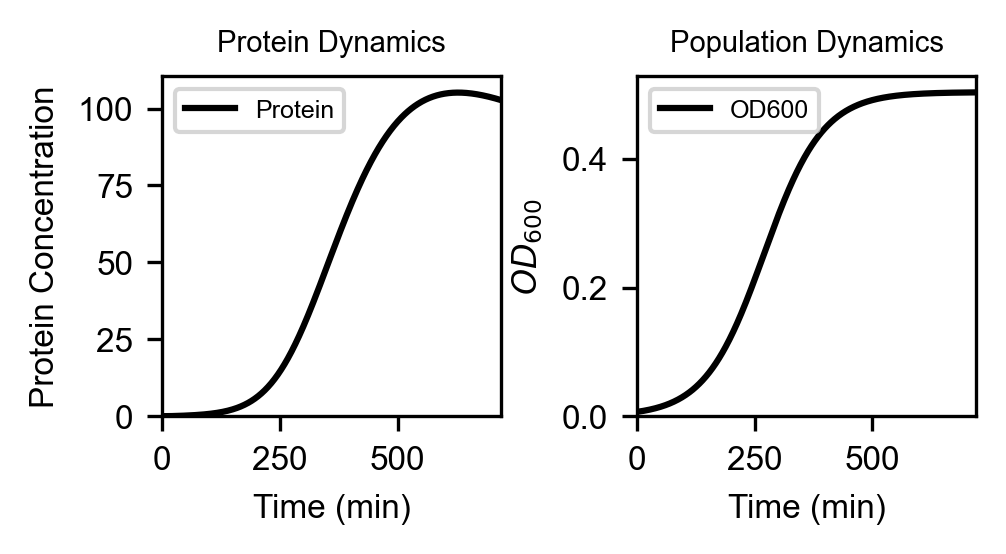

In [182]:
# Plot Model simulation
# fig, ax = plt.subplots(1,3, figsize=(7, 1.5), dpi = 300)
fig, ax = plt.subplots(1,2, figsize=(3.5, 1.5), dpi = 300)
plt.subplots_adjust(wspace=0.4)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd_model = 1

# # plot mRNA
# id = 0
# ax[id].plot(results['time'], results['M'], 'k', label='mRNA')
# ax[id].set_xlabel('Time (min)')
# ax[id].set_ylabel('mRNA Concentration')
# ax[id].set_title('mRNA Dynamics')
# ax[id].legend(loc='best')
# ax[id].set_xlim((0, 960))
# ax[id].set_ylim((0))

# plot Protein
id = 0
ax[id].plot(results['time'], results['Pm'], 'k', label='Protein')
ax[id].set_xlabel('Time (min)')
ax[id].set_ylabel('Protein Concentration')
ax[id].set_title('Protein Dynamics')
ax[id].legend(loc='best')
ax[id].set_xlim((0, t_final))
ax[id].set_ylim((0))

# plot Growth
id = 1
ax[id].plot(results['time'], results['C'], 'k', label='OD600')
ax[id].set_xlabel('Time (min)')
ax[id].set_ylabel(r'$OD_{600}$')
ax[id].set_title('Population Dynamics')
ax[id].legend(loc='best')
ax[id].set_xlim((0, t_final))
ax[id].set_ylim((0))

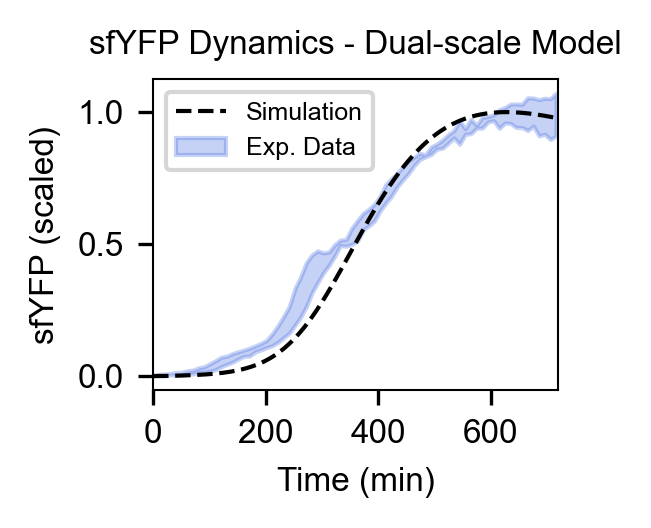

In [183]:
# Compare with experimental data for sfYFP 

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 6
})
tick_fontsize = 8

fig_size = 2,1.8
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region

# ===============================
# Compute means, stds, and bounds
# ===============================
FL_avg = np.mean([FL_1, FL_2, FL_3], axis=0)
FL_max = max(FL_avg)

mean_exp_FL = np.mean([FL_1, FL_2, FL_3], axis=0)/FL_max
std_exp_FL  = np.std([FL_1, FL_2, FL_3], axis=0)/FL_max
upper_FL, lower_FL = mean_exp_FL + std_exp_FL, mean_exp_FL - std_exp_FL


fig, ax = plt.subplots(figsize=fig_size , dpi = 300)

# Model simulations 
ax.plot(
    results['time'], results['Pm'] / np.max(results['Pm']),
    '--', label="Simulation", color='black', linewidth=lwd
)
ax.fill_between(
    time_1, upper_FL, lower_FL,
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)


# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics - Dual-scale Model')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='upper left')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
plt.savefig('sfYFP_dual_scale_dynamics.png', dpi=300, bbox_inches='tight', transparent=True)

### Step 7: Compile the single-scale model reaction network 

In [184]:
## Construct the minimal single-scale model 

# Reaciton Objects

dp_ss = 0.005 # Need a little higher degradation rate so that the protein reaches steady state within the experimental timescale
r_tx_single_scale = Reaction.from_massaction([], [M], k_forward = 3)
r_dm_single_scale = Reaction.from_massaction([M], [], k_forward = 0.15)
r_tl_single_scale = Reaction.from_massaction([M], [M, P], k_forward = 0.1)
r_dp_single_scale = Reaction.from_massaction([P], [], k_forward = dp_ss)
r_fold_single_scale = Reaction.from_massaction([P], [Pm], k_forward = 1/tau_folding)
r_dp_Pm_single_scale = Reaction.from_massaction([Pm], [], k_forward = dp_ss)

print("\nReactions can be printed as well:\n", r_tx_single_scale,"\n", r_dm_single_scale, "\n", r_tl_single_scale,
      "\n", r_dp_single_scale, "\n", r_fold_single_scale, "\n", r_dp_Pm_single_scale)

#create an initial condition 
initial_concentration_dict_single_scale = {M:0, P:0, Pm:0}

# Make a CRN
CRN_single_scale = ChemicalReactionNetwork(species = [M, P, Pm], reactions = [r_tx_single_scale, r_dm_single_scale, r_tl_single_scale,
                                                               r_dp_single_scale, r_fold_single_scale, r_dp_Pm_single_scale],
                              initial_concentration_dict = initial_concentration_dict_single_scale)



Reactions can be printed as well:
  --> M 
 M -->  
 M --> M+P 
 P -->  
 P --> Pm 
 Pm --> 


### Step 8: Simulate and plot the results

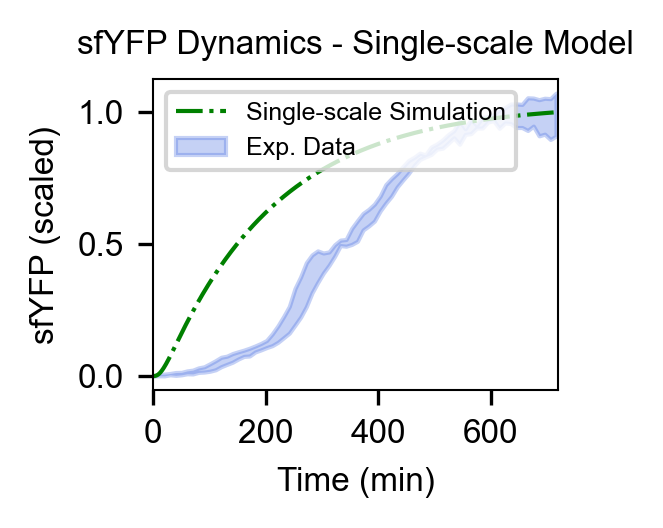

In [185]:
## Simulate with bioscrape (deterministic)
# This returns a pandas DataFrame with 'time' and species columns (by string name)
results_single_scale = CRN_single_scale.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=initial_concentration_dict_single_scale)


# Compare with experimental data for sfYFP 

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 6
})
tick_fontsize = 8

fig_size = 2,1.8
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region

# Plot Pm from single-scale model
fig, ax = plt.subplots(figsize=fig_size , dpi = 300)
ax.plot(
    results_single_scale['time'], results_single_scale['Pm'] / np.max(results_single_scale['Pm']),
    '-.', label="Single-scale Simulation", color='green', linewidth=lwd
)
ax.fill_between(
    time_1, upper_FL, lower_FL,
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)

# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics - Single-scale Model')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='upper left')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
#plt.savefig('sfYFP_single_scale_dynamics.png', dpi=300, bbox_inches='tight', transparent=True)

### Step 9: Compile the single-scale model reaction network with very high protein folding time

In [186]:
## Construct the minimal single-scale model 

# Reaciton Objects

tau_folding_max = 1000 #
dp_ss = 0.005 # Need a little higher degradation rate so that the protein reaches steady state within the experimental timescale
r_tx_single_scale = Reaction.from_massaction([], [M], k_forward = 3)
r_dm_single_scale = Reaction.from_massaction([M], [], k_forward = 0.15)
r_tl_single_scale = Reaction.from_massaction([M], [M, P], k_forward = 0.1)
r_dp_single_scale = Reaction.from_massaction([P], [], k_forward = dp_ss)
r_fold_single_scale_max = Reaction.from_massaction([P], [Pm], k_forward = 1/tau_folding_max)
r_dp_Pm_single_scale = Reaction.from_massaction([Pm], [], k_forward = dp_ss)

print("\nReactions can be printed as well:\n", r_tx_single_scale,"\n", r_dm_single_scale, "\n", r_tl_single_scale,
      "\n", r_dp_single_scale, "\n", r_fold_single_scale_max, "\n", r_dp_Pm_single_scale)

#create an initial condition 
initial_concentration_dict_single_scale = {M:0, P:0, Pm:0}

# Make a CRN
CRN_single_scale_max_folding = ChemicalReactionNetwork(species = [M, P, Pm], reactions = [r_tx_single_scale, r_dm_single_scale, r_tl_single_scale,
                                                               r_dp_single_scale, r_fold_single_scale_max, r_dp_Pm_single_scale],
                              initial_concentration_dict = initial_concentration_dict_single_scale)



Reactions can be printed as well:
  --> M 
 M -->  
 M --> M+P 
 P -->  
 P --> Pm 
 Pm --> 


### Step 10: Simulate and plot the results

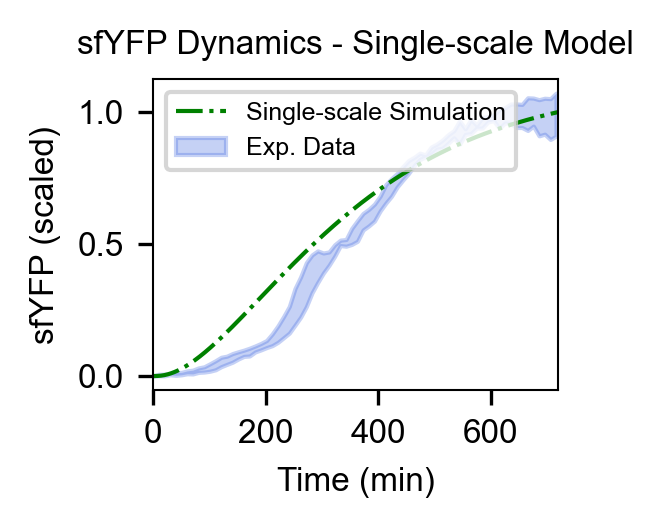

In [187]:
## Simulate with bioscrape (deterministic)
# This returns a pandas DataFrame with 'time' and species columns (by string name)
results_single_scale_max_folding = CRN_single_scale_max_folding.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=initial_concentration_dict_single_scale)


# Compare with experimental data for sfYFP 

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 6
})
tick_fontsize = 8

fig_size = 2,1.8
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region

# Plot Pm from single-scale model
fig, ax = plt.subplots(figsize=fig_size , dpi = 300)
ax.plot(
    results_single_scale_max_folding['time'], results_single_scale_max_folding['Pm'] / np.max(results_single_scale_max_folding['Pm']),
    '-.', label="Single-scale Simulation", color='green', linewidth=lwd
)
ax.fill_between(
    time_1, upper_FL, lower_FL,
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)

# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics - Single-scale Model')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='upper left')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
#plt.savefig('sfYFP_single_scale_dynamics.png', dpi=300, bbox_inches='tight', transparent=True)

### Compare single-scale and dual-scale model predictions

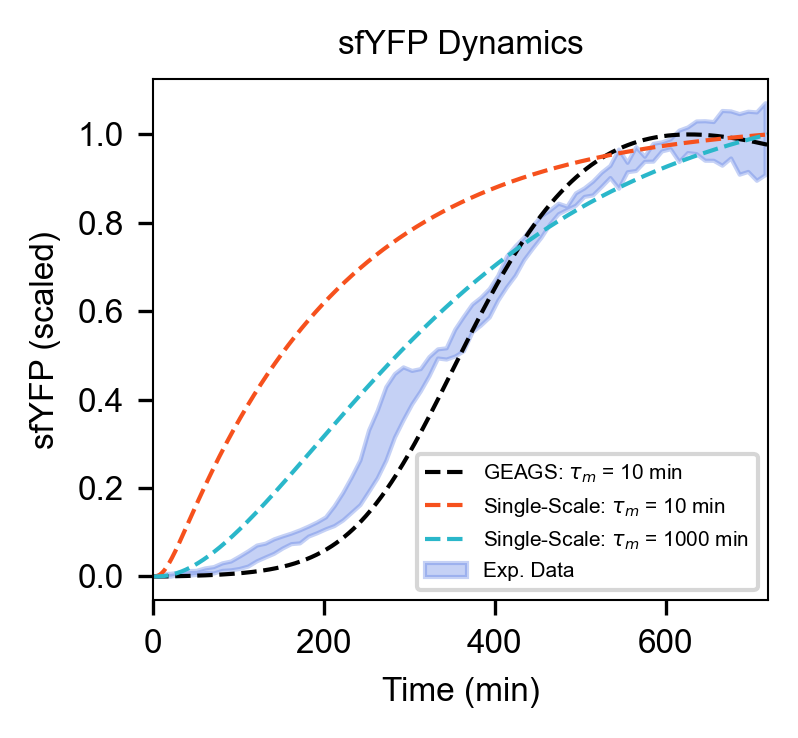

In [188]:
# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 5
})
tick_fontsize = 8

color_dict = {
    'Min. kfold': "#2ab7ca",
    'Norm. kfold': '#f6511d',
    'Avg': '#000000',
    'Exp. data': "royalblue"}

fig_size = 2.7,2.5
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region



fig, ax = plt.subplots(figsize=fig_size , dpi = 300)

# Model simulations 
# Dual-scale model simulations
ax.plot(
    results['time'], results['Pm'] / np.max(results['Pm']),
    '--', label=r"GEAGS: $\tau_{m}$ = " + f"{tau_folding} min", color='black', linewidth=lwd
)

ax.plot(
    results_single_scale['time'], results_single_scale['Pm'] / np.max(results_single_scale['Pm']),
    '--', label=r"Single-Scale: $\tau_{m}$ = " + f"{tau_folding} min", color=color_dict['Norm. kfold'], linewidth=lwd
)

ax.plot(
    results_single_scale_max_folding['time'], results_single_scale_max_folding['Pm'] / np.max(results_single_scale_max_folding['Pm']),
    '--', label=r"Single-Scale: $\tau_{m}$ = " + f"{tau_folding_max} min", color=color_dict['Min. kfold'], linewidth=lwd
)


# Experimental data
ax.fill_between(
    time_1, upper_FL, lower_FL,
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)


# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='lower right')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
#plt.savefig('sfYFP_model_comparison.tif', dpi=300, bbox_inches='tight', transparent=True)